**Montage de Google Drive :** Ce code permet de monter Google Drive afin d'accéder aux fichiers audio directement depuis Google Colab. Cela facilite la gestion des fichiers et leur utilisation dans l'analyse.

In [ ]:
# Accès à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installation des dépendances** :


*   **Librosa** pour l'extraction des caractéristiques audio
*   **Panda** pour la manipulation des données
*   **Joblib** pour la sauvegarde des modèles
*   **Scikit-learn** pour les algorithmes d'apprentissage automatique
*   **Matplotlib**` pour la visualisation des données








In [ ]:
# Installation des dépendances
!pip install librosa
!pip install joblib
!pip install scikit-learn
!pip install matplotlib

**Importation de Bibliothèques :** Importe toutes les bibliothèques nécessaires pour le traitement audio, la manipulation des données, la normalisation, la réduction dimensionnelle, le clustering et la mesure des distances


In [ ]:
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
from sklearn.metrics import silhouette_score
import scipy.spatial.distance as distance

**Extraction des caractéristiques audio :** Charge un fichier audio et extrait plusieurs types de caractéristiques audio : MFCC, spectrogramme, chroma, et contraste spectral. Si une erreur se produit, elle est affichée et None est retourné


In [ ]:
def extract_features(file_path):
    try:
        signal, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
        spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)
        features = np.concatenate((np.mean(mfccs, axis=1), np.mean(spectrogram, axis=1),
                                   np.mean(chroma, axis=1), np.mean(contrast, axis=1)))
        return features
    except Exception as e:
        print(f"Erreur lors de l'extraction des caractéristiques pour {file_path}: {e}")
        return None

**Détermination de la dimensionnalité des caractéristiques** : Calcule et retourne la dimension totale des caractéristiques extraites.


In [ ]:
def feature_dimensionality():
    n_mfcc = 13
    n_mels = 128
    n_chroma = 12
    n_contrast = 7
    return n_mfcc + n_mels + n_chroma + n_contrast

**Traitement des fichiers audio** : On parcourt tous les fichiers .mp3 dans un répertoire donné, extrait les caractéristiques et les stocke dans une liste.

In [ ]:
def process_audio_files(audio_files_path):
    features_list = []
    for file in os.listdir(audio_files_path):
        if file.endswith('.mp3'):
            path = os.path.join(audio_files_path, file)
            features = extract_features(path)
            if features is not None:
                features_list.append(features)
    return np.array(features_list)

***Normalisation et sauvegarde des caractéristiques : *** Extrait les caractéristiques des fichiers audio, les normalise avec StandardScaler, puis les sauvegarde dans un fichier CSV et le scaler dans un fichier joblib.

In [ ]:
audio_files_path = '/content/drive/MyDrive/datamemoire'
features_array = process_audio_files(audio_files_path)
scaler = StandardScaler().fit(features_array)
normalized_features = scaler.transform(features_array)

df = pd.DataFrame(normalized_features)
csv_file_name = '/content/drive/MyDrive/filecsv/normalized_audio_features.csv'
df.to_csv(csv_file_name, index=False)

scaler_file_name = '/content/drive/MyDrive/scaler/scaler.joblib'
dump(scaler, scaler_file_name)

['/content/drive/MyDrive/scaler/scaler.joblib']

**Lecture des caractéristiques et réduction dimensionnelle :** On charge les caractéristiques normalisées depuis le CSV, applique une réduction dimensionnelle avec PCA et visualise les deux premières composantes principales

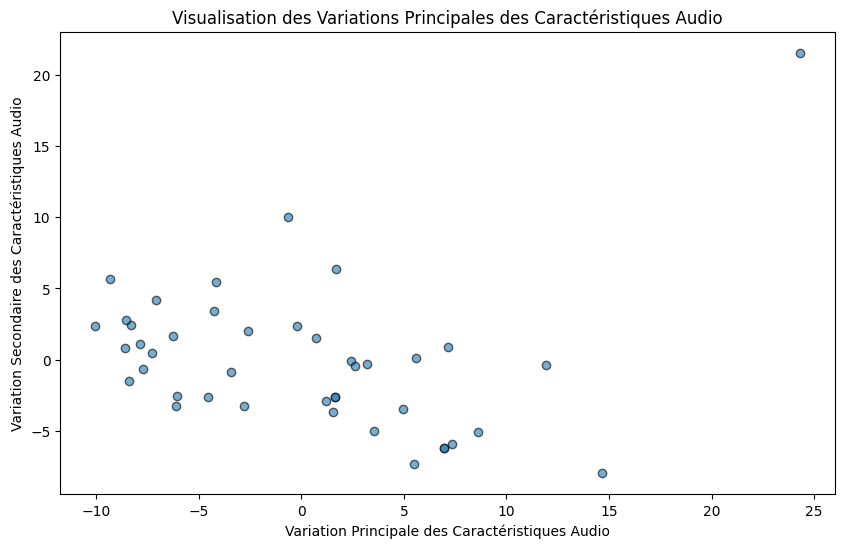

In [ ]:
df = pd.read_csv(csv_file_name)

pca = PCA(n_components=2)
reduced_df = pca.fit_transform(df)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_df[:, 0], reduced_df[:, 1], alpha=0.6, edgecolors='k')
plt.title('Visualisation des Variations Principales des Caractéristiques Audio')
plt.xlabel('Variation Principale des Caractéristiques Audio')
plt.ylabel('Variation Secondaire des Caractéristiques Audio')
plt.show()

**Calcul des distances k-plus-proches et visualisation :** On calcule les distances aux k-plus-proches voisins pour déterminer un seuil pour DBSCAN et visualise ces distances

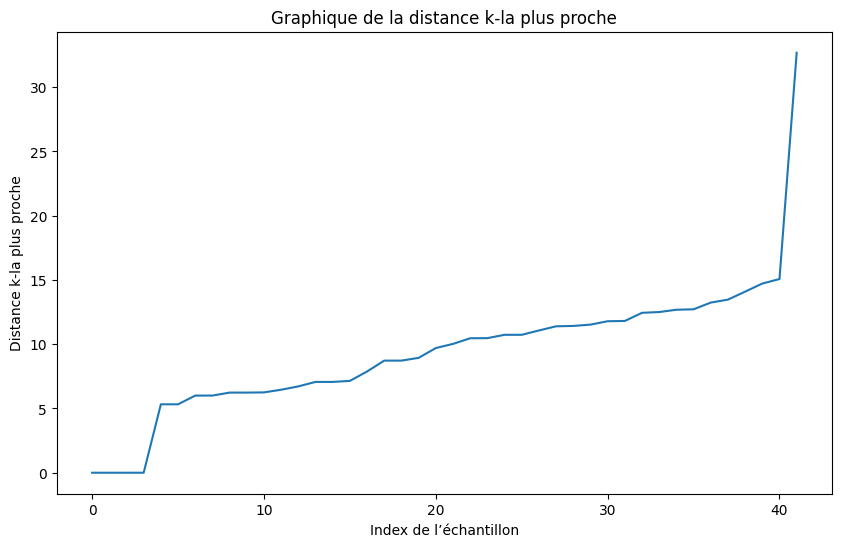

In [ ]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Graphique de la distance k-la plus proche')
plt.xlabel('Index de l’échantillon')
plt.ylabel('Distance k-la plus proche')
plt.show()

*** Clustering DBSCAN : *** On effectue le clustering avec DBSCAN en ajustant eps et min_samples en fonction de la dimensionnalité des caractéristiques, puis visualise les clusters formés.

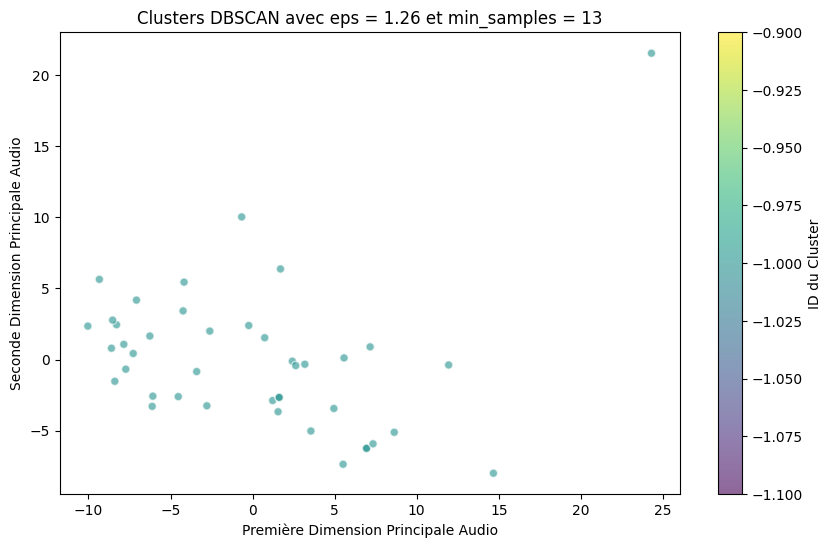

In [ ]:
# Ajustement des paramètres de DBSCAN basé sur la dimensionnalité
dim_features = feature_dimensionality()
eps_value = np.sqrt(dim_features) * 0.1
min_samples_value = int(np.ceil(np.sqrt(dim_features)))  # Min samples basé sur la racine carrée de la dimension
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(df)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_df[:, 0], reduced_df[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolors='w', marker='o')
plt.colorbar(label='ID du Cluster')
plt.title(f'Clusters DBSCAN avec eps = {eps_value:.2f} et min_samples = {min_samples_value}')
plt.xlabel('Première Dimension Principale Audio')
plt.ylabel('Seconde Dimension Principale Audio')
plt.show()

**Identification des duplicatas :** On charge le scaler sauvegardé, extrait et normalise les caractéristiques d'un nouveau morceau, puis compare ce morceau aux morceaux existants en utilisant la distance cosinus pour identifier des duplicatas potentiels.

In [ ]:
scaler = load('/content/drive/MyDrive/scaler/scaler.joblib')

nouveau_morceau_path = '/content/drive/MyDrive/newfile/RequiemMassinDMinorK626IIILacrimosa.mp3'
nouveau_morceau_features = extract_features(nouveau_morceau_path).reshape(1, -1)
nouveau_morceau_features_normalises = scaler.transform(nouveau_morceau_features)
morceaux_existants_features = df.to_numpy()

distances = distance.cdist(nouveau_morceau_features_normalises, morceaux_existants_features, 'cosine')
seuil_similarity = 0.05
index_morceau_proche = np.argmin(distances)
if distances[0][index_morceau_proche] < seuil_similarity:
    print(f"Le nouveau morceau est un duplicata potentiel du morceau à l'index {index_morceau_proche}.")
else:
    print("Le nouveau morceau est considéré comme unique.")

Le nouveau morceau est un duplicata potentiel du morceau à l'index 41.


**Calcul du Silhouette Score :** On calcule et affiche le Silhouette Score pour évaluer la qualité du clustering DBSCAN, si plus d'un cluster valide a été trouvé

In [ ]:
if len(set(clusters)) > 1 and np.any(clusters != -1):
    score = silhouette_score(df, clusters)
    print("Silhouette Score: ", score)
else:
    print("DBSCAN a produit un seul cluster.")

DBSCAN a produit un seul cluster.
